# snsTOOLS

## plot manipulations

In [7]:
''' Alter or add elements of/to a seaborn plot
'''
import matplotlib as mpl
# allows one to run matplotlib and seaborn headless
mpl.use('Agg') 
import matplotlib.pyplot as plt
import numpy as np
import PIL
import textwrap
from PIL import ImageDraw, ImageFont, Image
import logging


def rename_xtick(df, col, counts=True,  name2label={}, order=[]):
    ''' Get the value counts of each unique entry in the given column
        and store it in a list along with the values name.
        
    Args:
        df: DataFrame
        col: column/category to extract xtick labels and counts from
        counts: whether to display the value counts or not
        order: manually sets the order in which the xticks appear in the plot
        name2label: a dictionary where the key is the current x label and
                    the item is the label to rename it to
        
    Returns:
        list of xtick labels and their value counts 
    
    Notes:
        order only works if the parsed column is not already a category
    
    Example:
        df = sns.load_dataset("tips")
        n = rename_xtick(df, col='day', counts=True)
        ax = sns.violinplot(x="day", y="total_bill", data=df)
        ax.set_xticklabels(n)
    '''
    if not order:
        order = df[col].unique()
   
    if df[col].dtypes.name != 'category':
        df[col] = convert2category(df[col], order)
    
    # store the value counts of the col entries
    sizes = df.groupby(col).size().iteritems()
    
    if counts is True:
        name_count = [(name+"\n"+"n = "+str(n)) for name, n in sizes]
    else:
        name_count = [(name+"\n") for name, n in sizes]
    
    name_change = []
    for info in name_count:
        name = info.split("\n")[0]
        if name in list(name2label.keys()):
            new_name = info.replace(name, name2label.get(name))
            name_change.append(new_name)
        else:
            name_change.append(info)
            
    logging.warning("Ensure xticks are renamed as expected!")                    
    return name_change




def lines_between_plots(df, x1, x2, height, vertical, column, value): 
    ''' Place floating lines between two plots at a given
        height and line height and place a given value about 
        said line.

    Args: 
        x1: x-pos to start from 
        x2: x-pos to end at
        height: y-pos at which the vertical line will begin from
        vertical: length of the vertical lines
        columns: DataFrame column name
        value: string to place atop the horizontal line
        
    Notes:
        taken from http://tinyurl.com/zpjtbjz
    
    Returns:
        lines between two points on an existing plot which uses
        the given df and column data
    '''
    y, h, col = height, vertical, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, value, ha='center', va='bottom', color=col)



def RoundToSigFigs( x, sigfigs ):
    ''' Rounds the value(s) in x to the number of significant figures in sigfigs.
    
    Args:
        x: float
        sigfigs: number of significant figures

    Note:
        sigfigs must be an integer type and store a positive value.
        x must be a real value or an array like object containing only real values.
    '''
    __logBase10of2 = 3.010299956639811952137388947244930267681898814621085413104274611e-1
    if not ( type(sigfigs) is int or np.issubdtype(sigfigs, np.integer)):
        raise TypeError( "RoundToSigFigs: sigfigs must be an integer." )

    if not np.all(np.isreal( x )):
        raise TypeError( "RoundToSigFigs: all x must be real." )

    if sigfigs <= 0:
        raise ValueError( "RoundtoSigFigs: sigfigs must be positive." )

    mantissas, binaryExponents = np.frexp( x )

    decimalExponents = __logBase10of2 * binaryExponents
    intParts = np.floor(decimalExponents)

    mantissas *= 10.0**(decimalExponents - intParts)

    return np.around( mantissas, decimals=sigfigs - 1 ) * 10.0**intParts



def create_subplot(files, outfile, size=(2000,1600), sub_fig=None, font="Verdana.ttf"):
    ''' Merge multiple images of similar size into one image 
        
    Args:
        files: list of files to merge
        outfile: name of output file
        size: pixel size of the output (width, height)
        sub_fig: add figure number to the corner of each subplot 
        font: font used for sub_fig markings
        
    Returns:
        An image/canvas with all the parsed subplots appended together
        
    Notes:
        sub_fig only works for upto 4 subplots
        
    '''
    # Correct the resolution size given based on average dimensions of all imgs in files
    w, h = correct_size(files, size)
    
    # canvas in which all subplots will be placed upon
    canvas = PIL.Image.new("RGB", (w, h), 'white')
    
    for index, f in enumerate(files):
        # open each individual plot
        img = PIL.Image.open(f)
        
        # alter the height and width for each plot so they can fit snuggly on the canvas
        sub_h = int(h/2) 
        sub_w = int(w/(len(files)/2))
        img.thumbnail((sub_w, sub_h), PIL.Image.ANTIALIAS)
        
        # estimate where the plot will be placed on the canvas
        x = index // 2 * sub_w 
        y = index % 2 * sub_h
        img_w, img_h = img.size # these measurements are diff from sub_h and sub_w, no idea why
        print('pos {0},{1} size {2},{3}'.format(x, y, img_w, img_h))
        canvas.paste(img, (x, y, x + img_w, y + img_h))

    if sub_fig:
        fnt_size = int((w+h)/120)
        fnt = PIL.ImageFont.truetype(font, fnt_size)
        PIL.ImageDraw.Draw(canvas).text((sub_w/40, 0), "a", fill=0, font=fnt)
        PIL.ImageDraw.Draw(canvas).text((sub_w+(sub_w/20), 0), "c", fill=0, font=fnt)
        PIL.ImageDraw.Draw(canvas).text((sub_w/40,sub_h), "b", fill=0, font=fnt)
        PIL.ImageDraw.Draw(canvas).text((sub_w+(sub_w/20),sub_h), "d", fill=0, font=fnt)

    canvas.save(outfile)


def correct_size(f, size):
    ''' Adjust the given size so that the given files can fit 
        closely side by side within a subplot.
    
    Args:
        f: list of image files
        size: resoltion in pixels in a tuple (width, height)
    
    Returns:
        altered size in a tuple
    
    '''
    # get the average width and height for all parsed image files
    avg_w = sum([Image.open(size).size[0]for size in f]) /len(f)
    avg_h = sum([Image.open(size).size[1]for size in f]) /len(f)
    
    # calulate the ratio of width to height and use ratio to recalculate height
    r = avg_w/avg_h
    w, h = size
    h = int((w/r)*(4/len(f)))
    
    return (w, h)
    

def figure_box(f, msg, outfile, extend=100, font="Verdana.ttf", font_size=20, x_text=0):
    ''' Add a figure box label below the given image

    Args:
        f: filename of the image which will be used as input
        msg: message to place in the figure box
        outfile: name of output
        extend: increase the y-axis of the image f by the given number
        font: font type to use
        font_size: font size
        x_text: specify the position where the text begins on the x-axis
    
    '''
    img = PIL.Image.open(f)
    x, y = img.size
    result = PIL.Image.new("RGB", (x, y+extend), 'white')
    result.paste(img, (0, 0))

    fnt = PIL.ImageFont.truetype(font, font_size)
    draw_word_wrap(img=result, text=msg, 
                   xpos=0+x_text, ypos=y, 
                   max_width=x-(x_text*2), font=fnt)


    result.save(outfile)



def draw_word_wrap(img, text, xpos=0, ypos=0, max_width=130, fill=(0,0,0), 
                   font=ImageFont.truetype("Verdana.ttf", 50)):
    ''' Draw the given ``text`` to the x and y position of the image, using
        the minimum length word-wrapping algorithm to restrict the text to
        a pixel width of ``max_width.``

    Args:
        img: image to draw/write upon
        text: message to draw/write
        xpos: x position to begin writing
        ypos: y position to begin writing
        max_width: maximum length on y-axis before text wrapping begins
        fill: text colour
        font: font and font size
    
    Notes:
        Taken from: https://gist.github.com/atorkhov/5403562
    '''

    draw = PIL.ImageDraw.Draw(img)
    text_size_x, text_size_y = draw.textsize(text, font=font)
    remaining = max_width
    space_width, space_height = draw.textsize(' ', font=font)

    # use this list as a stack, push/popping each line
    output_text = []

    # split on whitespace...    
    for word in text.split(None):
        word_width, word_height = draw.textsize(word, font=font)
        if word_width + space_width > remaining:
            output_text.append(word)
            remaining = max_width - word_width
        else:
            if not output_text:
                output_text.append(word)
            else:
                output = output_text.pop()
                output += ' %s' % word
                output_text.append(output)
            remaining = remaining - (word_width + space_width)

    for text in output_text:
        draw.text((xpos, ypos), text, font=font, fill=fill)
        ypos += text_size_y


def convert2grayscale(f):
    ''' Convert a colour image to grascale
    
    Args:
        f: absolute path to file to be converted
        
    Notes:
        This overwrites the original file
    '''
    img = Image.open(f).convert('LA')
    img.save(f)



/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## PieChart

In [257]:
%matplotlib inline  
from scipy import stats
import plot_manipulations as pm

def split_piechart(df, group, qual, colors=['salmon', 'turquoise',  'silver', 'white'], 
                   outfile=None, font_size=13, title=""):
    ''' Split a dataframe into two groups and plot the data from the given column (qual)
        on a piechart side-by-side and perform the appropriate statistical test to get a
        pvalue.
    
    Args: 
        df: Pandas DataFrame
        group: a column in df containing categorical data that has two unique values
        qual: a column in df containing categorical data
        colors: list of colors for piechart segments to parse to matplotlib
        outfile: image output file name
    
    Returns:
        matplotlib piechart
    '''
    # drop rows without values in group and fill in missing data in qual
    df = df.dropna(subset = [group])
    df[qual] = df[qual].fillna(value='Unknown')
    
    # figure size, background color to white (0), title, label font sizez and get labels
    ax = plt.figure(figsize=(15,12), facecolor="1").gca()
    plt.tick_params(axis='both', which='major', labelsize=13.5) # xtick label sizes
    plt.title(title, fontsize=font_size*2) 
    mpl.rcParams['font.size'] = font_size
    divisions = df[qual].unique()
    
    # get the percentages of the qual counts in each group, remove if qual not present in group, and plot them as piecharts
    group1 = df[df[group] == df[group].unique()[0]]
    group1_percent = [len(group1[group1[qual] == x]) / len(group1) for x in divisions]
    group1_percent, names = remove_zeros(group1_percent, divisions)
    ax.pie(group1_percent, labels=names,
            colors=colors, shadow=False, autopct='%1.1f%%', 
            center=(0,0), startangle=90) 
    
    group2 = df[df[group] == df[group].unique()[1]]
    group2_percent = [len(group2[group2[qual] == x]) / len(group2) for x in divisions]
    group2_percent, names = remove_zeros(group2_percent, divisions)
    ax.pie(group2_percent, labels=names,
           colors=colors, shadow=False, autopct='%1.1f%%', 
           center=(2.5,0), startangle=90)
        
    # set the x ticks and labels 
    ax.axis('equal')
    ax.set_xticks([0, 2.5])
    xticklabels = ["{}:\nn = {}".format(x,len(df[df[group] == x ])) for x in df[group].unique()]
    ax.set_xticklabels(xticklabels)
    ax.tick_params(labelsize=font_size)
    
    # create a table for statistical testing and generate pvalue between the two groups
    table = df.groupby([group, qual]).size().unstack(1).fillna(0.0)
    array = table.values.tolist()
    if len(divisions) == 2:
        oddsratio, pvalue = stats.fisher_exact(array)
    else:
        chi2, pvalue, dof, expected = stats.chi2_contingency(array)
        
    pm.lines_between_plots(df, 0,2.5,1.5, 0.1, "l", "p = "+str(round(pvalue,3)))

    # decide whether to save or not
    if outfile:
        ax.figure.savefig(outfile)
        pass
    

    
def remove_zeros(percent, strings):
    ''' Identify any zeros in percent, get their
        indexes and remove the values in percent 
        and strings with said indexes.
    
    Args:
        percent: list of integers
        strings: list of strings
    '''
    if 0 in percent:
        index = [x[0] for x in enumerate(percent) if x[1] == 0][0]
        strings = list(strings[:index]) + list(strings[index+1 :])
        percent = percent[:index] + percent[index+1:]
        return remove_zeros(percent, strings)

    else:
        return (percent, strings)



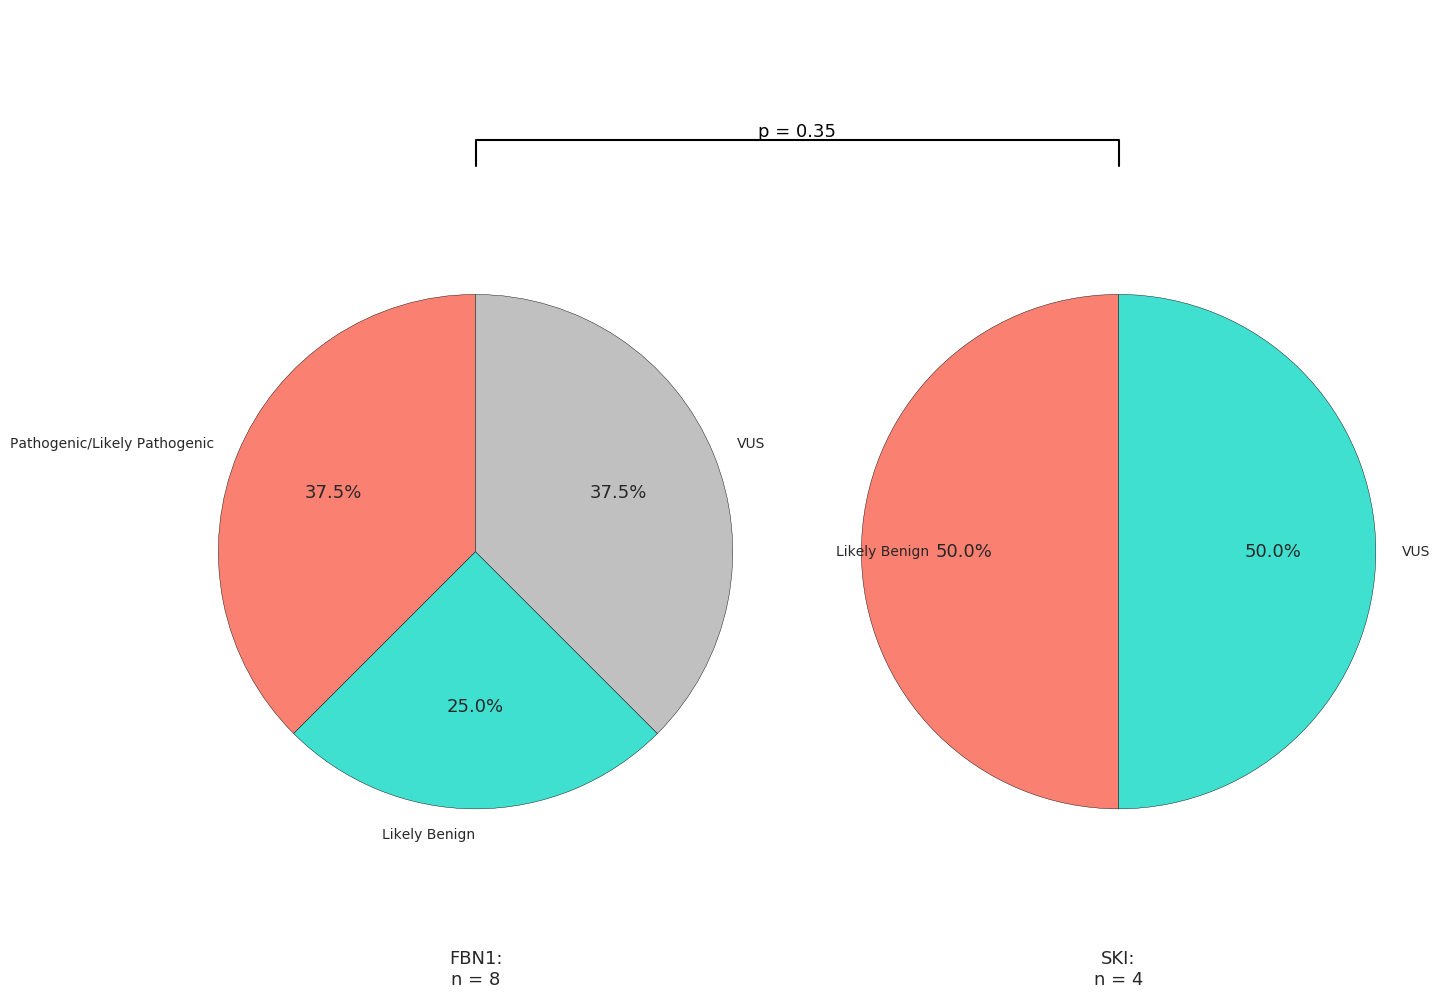

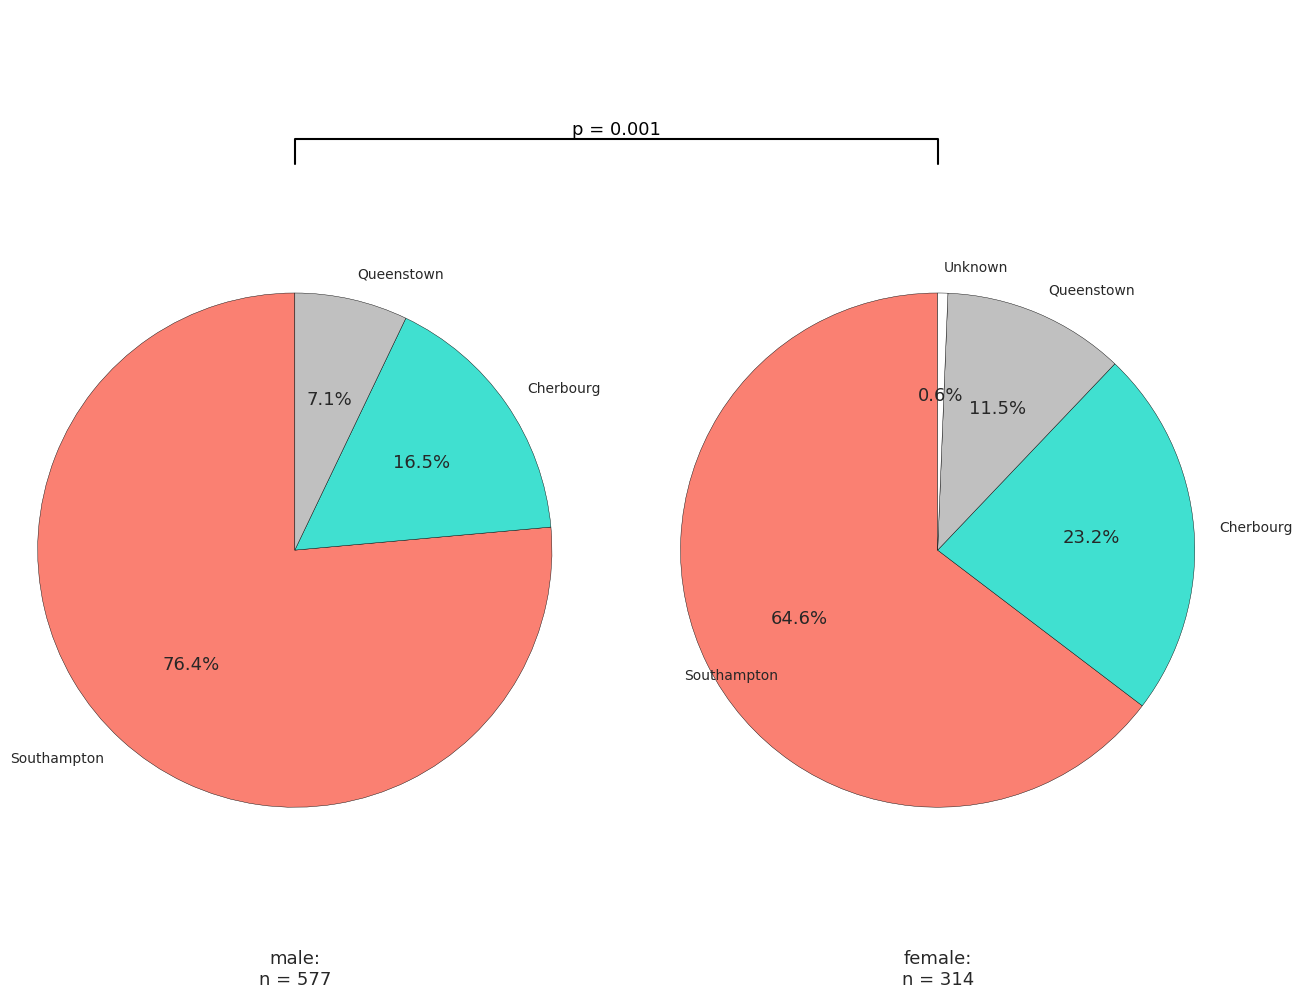

In [258]:
import pandas as pd 

df1 = pd.DataFrame(columns=['Sample', 'Category', 'AB', 'Symbol', 'Exon'],
         data=[
               ['GH', 'Pathogenic/Likely Pathogenic',  0.2, 'FBN1', '1/7'],
               ['GH', 'Likely Benign',  0.5, 'FBN1', '1/7'],
               ['JP', 'Likely Benign',  0.5, 'FBN1', '2/7'],
               ['IO', 'Likely Benign',  0.3, 'SKI', '4/7'],
               ['IO', 'Likely Benign', 0.7, 'SKI', '1/7'],
               ['IO', 'VUS', 0.6, 'SKI', '1/7'],
               ['PO', 'VUS', 0.9, 'SKI', '2/7'],
               ['LO', 'VUS',  0.1, 'FBN1', '7/7'],
               ['QU', 'Pathogenic/Likely Pathogenic',  0.4, 'FBN1', '3/7'],
               ['RM', 'Pathogenic/Likely Pathogenic',  0.2, 'FBN1', '4/7'],
               ['RM', 'VUS',  0.6, 'FBN1', '4/7'],
               ['QM', 'VUS', 0.1, 'FBN1', '7/7']

               ])

df2 = pd.DataFrame(columns=['Sample', 'Category', 'AB', 'Symbol', 'Exon'],
                 data=[
                       ['GH', 'Pathogenic/Likely Pathogenic',  0.2, 'FBN1', '1/7'],
                       ['IO', 'VUS', 0.6, 'SKI', '1/7'],
                       ['PO', 'VUS', 0.9, 'SKI', '2/7'],
                       ['LO', 'VUS',  0.1, 'FBN1', '7/7'],
                       ['QU', 'Pathogenic/Likely Pathogenic',  0.4, 'FBN1', '3/7'],
                       ['RM', 'Pathogenic/Likely Pathogenic',  0.2, 'FBN1', '4/7'],
                       ['QM', 'VUS', 0.1, 'FBN1', '7/7'],
                       ['IO', 'Pathogenic/Likely Pathogenic', 0.7, 'SKI', '1/7'],
                       ['IO', 'Likely Benign', 0.7, 'SKI', '1/7'],
                       ['IO', 'Test', 0.7, 'SKI', '6/7'],

                       ])


split_piechart(df1,  group='Symbol', qual='Category', font_size=13)


import seaborn as sns
titanic = sns.load_dataset("titanic")
sum(titanic['embark_town'].value_counts().tolist())
split_piechart(titanic,  group='sex', qual='embark_town', font_size=13)


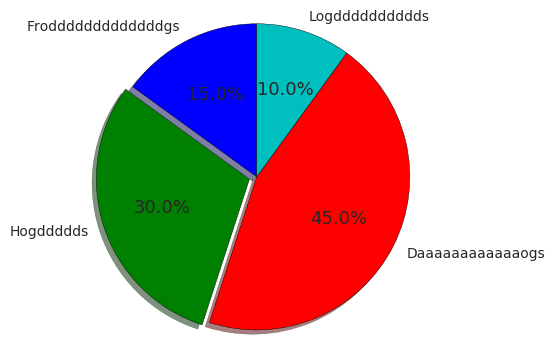

In [273]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frodddddddddddddgs', 'Hogddddds', 'Daaaaaaaaaaaaogs', 'Logdddddddddds'
sizes = [15, 30, 45, 10]
explode = (0, 0.05, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## data manipulations

In [3]:
def convert2category(column, label_order):
    ''' convert column to a category and set the order of the labels
    '''
    convert = pd.Series(column, dtype="category")
    structured_cat = convert.cat.set_categories(label_order)
    return structured_cat

def replace_series_strings(df, col, dic, substring=True):
    ''' Replace the the keys with the items of the given 
        dictionary for all strings or substrings in a
        given column

    Args:
        col: column name to replace strings
        dic: dictionary where the key is the string to replace with the item
        substrings: search and replace for either substrings (True) or any cell 
                    containing the given key (False)

    Returns:
        dataframe with the given column having all the
        entries identified as the key in the given dict
        replaced with the item in said dict
    '''
    if not isinstance(substring, bool):
        raise TypeError("substring argument must equal True or False")

    for string, correction in dic.items():
        if substring is True:
            df[col] = df[col].str.replace(string, correction)
        elif substring is False:
            df[col] = df[col].replace(".*"+string+".*", correction, regex=True)

    return df


## Duplicate Check

In [4]:
import numpy as np
import logging

def duplicate_resolver(df, col, column_list, dup_ends=['_2','_3', '_pool7A', '_pool10A'], warn=True):
    ''' Identify duplicate values in a given column and forward-fill the 
        missing data in the a given column list and subsequently 
        remove any rows that have missing data in all the cells
        in the column list.
    
    Args:
        df: DataFrame
        col: column of the df to check for duplicates
        column_list: the list of columns to check for missing data
        dup_end: characters which seperate the original and duplicate sample
        warn: print a warning detailing the col values
        
    Returns:
        modified df 
    
    Notes:
        if dup_ends = ['_2'] then GH and GH_2 in the given col would be considered
        duplicates
    '''
    # duplicate samples with different phenotype information are dealt with here 
    df = duplicate_column_checker(df, column_list, column=col)

    # get index numbers for all column in the list and filter out rows that have no data in these fields
    col_list_ix = [df.columns.get_loc(x) for x in column_list]
    remove_rows = df.apply(lambda x: identify_null_data(x, col_list_ix), axis=1)
    new_df = df[remove_rows]
    
    # warn user of removed rows 
    if warn:
        removed_rows_values = " ".join(df[~remove_rows][col].tolist())
        logging.warning("The rows containing the following values in column '{}' have been removed:\n{}".format(col, removed_rows_values))
    
    return new_df


def identify_null_data(x, col_ix):
    ''' Check whether we have any data in the fields in the given column indexes.

    Args:
        col_ix: a list of column indexes to be investigated for differences between duplicate samples
    
    Returns:
        False if only null or dash is present in the rows selected column, else True
    
    Notes:
        This function is intended to be used via the apply function in pandas e.g.
                df.apply(lambda x: identify_null_data(x, col_ix), axis=1)

    '''
    # start from column (index) and convert to a list and filter out duplicate values and NaNs
    column_cells = x[col_ix].tolist()
    all_row_cell_values = set([z for z in column_cells if str(z) != 'nan'])
    
    
    if len(all_row_cell_values) == 1 and "-" in all_row_cell_values:
        return False
    elif len(all_row_cell_values) == 0:
        return False
    else:
        return True



def duplicate_column_checker(df, columns_names, order=False, recurs=2, dup_ends=['_2','_3', '_pool7A', '_pool10A'],
                             column="Sample"):
    ''' Identify duplicate samples and verify whether they have the same data stored in the given columns.
        If one duplicate has NaN in its phenotype fields then copy the phenotype data from the
        other duplicate sample. If there are still differences between them, then report to user.

    Args:
        column_names: a list of column names to be investigated for differences between duplicates
        order: ascending - True or False
        recurs: utilised to stop the recursive function
        dup_end: characters which seperate the original and duplicate sample
        column: column in which to search & identify whether samples are duplicates

    Returns:
        a dataframe in which the duplicates differences in the given columns have been resolved 
        and/or communicated to the user
    '''    
    if recurs < 1:
        return df
    
    # replace all dashes with NaN
    df = df.replace('-', np.nan)
    
    # Identify which samples are duplicates and fill in a new column with the original samples name. This way all duplicates have the orginal sample name in its row.
    for dup in dup_ends:
        cond = ((df[column].str.endswith(dup)) & (df[column].str.len() > 4))
        df.ix[cond, 'same'] = df.ix[cond, column].str[:-(len(dup))]

    # replace NaN in same by entries in column
    df.same = df.same.combine_first(df[column])

    # sort columns first on same then column. column is reversed upon the funcs recursion
    df = df.sort_values(by=['same', column], ascending=[False, order]).reset_index()
    
    # get the clumn indexes for the given column names
    col_ix = [df.columns.get_loc(x) for x in columns_names]
        
    # assess whether the sample names in a row and the following row are duplicates and, if so, forward fill the fields described in column names
    for num in range(0, df.shape[0]-1):
        
        current_sam = df['same'].shift(-(num))[0]
        next_sam = df['same'].shift(-(num+1))[0]

        if current_sam == next_sam:
            
            df.iloc[num:num+2, col_ix] = df.iloc[num:num+2, col_ix].ffill(limit=1)
    
    #remove column index
    df.drop(['index'], axis=1, inplace=True)
    
    # do the same but reverse the order of secondary order
    return duplicate_column_checker(df, columns_names, order=True, recurs=recurs-1, dup_ends=dup_ends)
 
    
    

In [5]:
import pandas as pd

df = pd.DataFrame(columns=['Sample', 'Category', 'Age'],
         data=[
               ['GH', 'Pathogenic/Likely Pathogenic',  12],
               ['GH', 'Likely Benign',  np.nan],
               ['JP', 'Likely Benign',  32],
               ['IO', 'Likely Benign',  np.nan],
               ['IO', 'Likely Benign', 39],
               ['IO', 'VUS', 39],
               ['PO', 'VUS', 19],
               ['LO', 'VUS',  39],
               ['QU', 'Pathogenic/Likely Pathogenic',  9],
               ['RM', 'VUS',  np.nan],
               ['RM', 'VUS',  np.nan],
               ['QM', 'VUS', np.nan]

               ])

df

,Sample,Category,Age
0,GH,Pathogenic/Likely Pathogenic,12.0
1,GH,Likely Benign,NaN
2,JP,Likely Benign,32.0
3,IO,Likely Benign,NaN
4,IO,Likely Benign,39.0
5,IO,VUS,39.0
6,PO,VUS,19.0
7,LO,VUS,39.0
8,QU,Pathogenic/Likely Pathogenic,9.0
9,RM,VUS,NaN


In [7]:
duplicate_resolver(df, 'Sample', ['Age'])

RM RM QM IO


,Sample,Category,Age,same
2,QU,Pathogenic/Likely Pathogenic,9.0,QU
4,PO,VUS,19.0,PO
5,LO,VUS,39.0,LO
6,JP,Likely Benign,32.0,JP
8,IO,Likely Benign,39.0,IO
9,IO,VUS,39.0,IO
10,GH,Pathogenic/Likely Pathogenic,12.0,GH
11,GH,Likely Benign,12.0,GH


## Next Most Damaging

In [9]:
import pandas as pd


def create_new_most_damaging(old_most_dam, all_vars, AB=0.3, Gene="SKI", Exon="1/7"):
    ''' Replace the most damaging variant for each patients variant whom
        does not pass the allele balance threshold or whoms variant is
        within a known false positive gene and exon. If the existing most 
        damaging variant is the only variant for that patient, then said 
        variant will remain as the most damaging.
        
    Args:
        old_most_dam: existing dataframe which details the most damaging variant for each patient
        all_vars: a dataframe which contains all variants associated with the patients detailed in old_most_dam
        AB: allele balance minimum threshold
        Gene: gene in which a known false positive lies within 
        Exon: exon of said gene in which a known false positive lies within

    Returns:
        The old_most_dam df where the next most damaging variant has been 
        put in place of the old most damaging variant that did not pass 
        the allele balance threshold or was within a known false positive
    '''
    # drop duplicates (dropping is fine as they have been sorted by score)
    all_alt_vars = get_other_variants(old_most_dam, all_vars, AB, Gene, Exon)
    alt_most_dam = all_alt_vars.drop_duplicates(['Sample'])
    alt_most_dam['new_md'] = "Y"   # mark sample/variants 


    # append the newly selected most damaging, sort so these variants appear above old most damaging vars and drop duplicates so only new most damaging remain.
    append_most_dam = old_most_dam.append(alt_most_dam)
    append_most_dam = append_most_dam.sort_values(by=['Sample', 'new_md'])
    
    new_most_dam = append_most_dam.drop_duplicates('Sample')[old_most_dam.columns]
    
    return new_most_dam


def get_other_variants(most_damaging, all_var, AB, Gene, Exon):
    ''' Get a list of all sample names that contain a given false positive variant 
        or a variant which does not pass the threshold of the allele balance and 
        use it to get all other variants asociated with said sample.

    Args:   
        most_damaging: csv containg most damaging variants per sample
        all_var: all called variants assocaited with each sample referred to in most_damaging patients

    Returns:
        A modified all_vars df which has all the alternative variants for each
        sample within the most_damaging df except variants below the AB threshold
        and within false positives. Returned df is sorted by samle name and variant
        score.
        
    '''
    # copy and rename columns
    df = most_damaging.copy()
    df = df.fillna("-")

    # remove samples that have all NaN entries in the fields of interest
    df['all_nan'] = df.apply(lambda x: "Y" if (x['Symbol'] == "-" and x['Exon'] == "-" 
                             and x['AB'] == "-") else "N", axis=1)
    df = df[~df['all_nan'].str.contains("Y")]

    # convert AB to numeric
    df['AB'] = pd.to_numeric(df['AB'], errors='coerce')

    # filter for variants with SKI exon1 and AB < 0.3
    df = identify_unwanted(df, AB, Gene, Exon)   
    df = df[df['Unwanted'].str.contains("Y", na=False)]
                                               
    # list of all sample names 
    l = df['Sample'].tolist()
    
    # copy and rename columns
    all_vars = all_var.copy()
    
    # filter for only rows that contain sample name in the given list
    all_vars['cross'] = all_vars['Sample'].isin(l)
    all_vars = all_vars[all_vars['cross'] == True]
    
    # filter for variants with AB > 0.3 or aren't SKI exon 1
    all_vars = identify_unwanted(all_vars, AB, Gene, Exon)
    all_vars = all_vars[~all_vars['Unwanted'].str.contains("Y", na=False)]

    return all_vars 
 


def identify_unwanted(df, AB, Gene=None, Exon=None):
    ''' Identify and mark rows with variants which have a allele 
        balance less than the given threshold or a variant within 
        a known false positive
    '''
    mask = (df.AB < AB)
    
    if Gene and Exon:
        mask = (mask | ((df.Symbol.str.contains(Gene)) & (df.Exon.str.contains(Exon))))
    elif Gene:
        mask = (mask | (df.Symbol.str.contains(Gene)))
        
    df.ix[mask, 'Unwanted'] = "Y"
    
    return df



In [10]:
all_df = pd.DataFrame(columns=['Sample', 'Category', 'AB', 'Symbol', 'Exon'],
         data=[
               ['GH', 'Pathogenic/Likely Pathogenic',  0.2, 'FBN1', '1/7'],
               ['GH', 'Likely Benign',  0.5, 'FBN1', '1/7'],
               ['JP', 'Likely Benign',  0.5, 'FBN1', '2/7'],
               ['IO', 'Likely Benign',  0.3, 'SKI', '4/7'],
               ['IO', 'Likely Benign', 0.7, 'SKI', '1/7'],
               ['IO', 'VUS', 0.6, 'SKI', '1/7'],
               ['PO', 'VUS', 0.9, 'SKI', '2/7'],
               ['LO', 'VUS',  0.1, 'FBN1', '7/7'],
               ['QU', 'Pathogenic/Likely Pathogenic',  0.4, 'FBN1', '3/7'],
               ['RM', 'Pathogenic/Likely Pathogenic',  0.2, 'FBN1', '4/7'],
               ['RM', 'VUS',  0.6, 'FBN1', '4/7'],
               ['QM', 'VUS', 0.1, 'FBN1', '7/7']

               ])

most_dam_df = pd.DataFrame(columns=['Sample', 'Category', 'AB', 'Symbol', 'Exon'],
                 data=[
                       ['GH', 'Pathogenic/Likely Pathogenic',  0.2, 'FBN1', '1/7'],
                       ['JP', 'Likely Benign',  0.5, 'FBN1', '2/7'],
                       ['IO', 'VUS', 0.6, 'SKI', '1/7'],
                       ['PO', 'VUS', 0.9, 'SKI', '2/7'],
                       ['LO', 'VUS',  0.1, 'FBN1', '7/7'],
                       ['QU', 'Pathogenic/Likely Pathogenic',  0.4, 'FBN1', '3/7'],
                       ['RM', 'Pathogenic/Likely Pathogenic',  0.2, 'FBN1', '4/7'],
                       ['QM', 'VUS', 0.1, 'FBN1', '7/7']

                       ])

create_new_most_damaging(most_dam_df, all_df)


,Sample,Category,AB,Symbol,Exon
1,GH,Likely Benign,0.5,FBN1,1/7
3,IO,Likely Benign,0.3,SKI,4/7
1,JP,Likely Benign,0.5,FBN1,2/7
4,LO,VUS,0.1,FBN1,7/7
3,PO,VUS,0.9,SKI,2/7
7,QM,VUS,0.1,FBN1,7/7
5,QU,Pathogenic/Likely Pathogenic,0.4,FBN1,3/7
10,RM,VUS,0.6,FBN1,4/7


In [11]:
new = create_new_most_damaging(most_dam_df, all_df)
new

,Sample,Category,AB,Symbol,Exon
1,GH,Likely Benign,0.5,FBN1,1/7
3,IO,Likely Benign,0.3,SKI,4/7
1,JP,Likely Benign,0.5,FBN1,2/7
4,LO,VUS,0.1,FBN1,7/7
3,PO,VUS,0.9,SKI,2/7
7,QM,VUS,0.1,FBN1,7/7
5,QU,Pathogenic/Likely Pathogenic,0.4,FBN1,3/7
10,RM,VUS,0.6,FBN1,4/7
